In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [28]:
# 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [29]:
# 경로 정의
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'real_train_input.npy'
LABEL_TRAIN_DATA = 'real_train_label.npy'
DATA_CONFIGS = 'real_data_configs.json'

# 랜덤 시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'),allow_pickle = True)
#prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'rt', encoding='UTF8'))

In [30]:
# 모델 하이퍼파라미터 정의 
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 64 #512
NUM_EPOCHS = 10 #10
VALID_SPLIT = 0.1 #0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [31]:
# 모델 선언 및 컴파일 
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [32]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [33]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder already exists 



In [34]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
92/92 [==============================] - 9s 92ms/step - loss: 0.4272 - accuracy: 0.7858 - val_loss: 0.2177 - val_accuracy: 0.9386

Epoch 00001: val_accuracy improved from -inf to 0.93856, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 2/10
92/92 [==============================] - 7s 76ms/step - loss: 0.0715 - accuracy: 0.9747 - val_loss: 0.2079 - val_accuracy: 0.9386

Epoch 00002: val_accuracy did not improve from 0.93856
Epoch 3/10
92/92 [==============================] - 8s 83ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.2045 - val_accuracy: 0.9432

Epoch 00003: val_accuracy improved from 0.93856 to 0.94316, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 4/10
92/92 [==============================] - 8s 90ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.2215 - val_accuracy: 0.9432

Epoch 00004: val_accuracy did not improve from 0.94316
Epoch 5/10
92/92 [==============================] - 8s 89ms/step - loss: 0.0035 - accuracy: 0

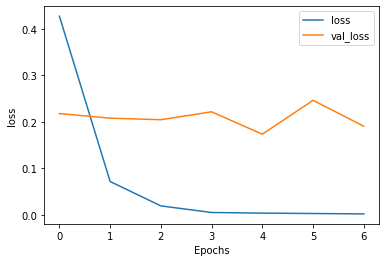

In [35]:
# 결과 플롯
plot_graphs(history, 'loss')

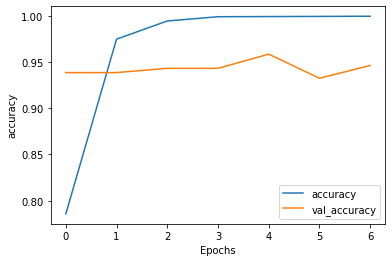

In [36]:
plot_graphs(history, 'accuracy')

In [37]:
# 결과 평가하기 
DATA_OUT_PATH = './data_out/'
INPUT_TEST_DATA = 'real_test_input.npy'
LABEL_TEST_DATA = 'real_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [38]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [39]:
model.evaluate(test_input, test_label_data)

204/204 [==============================] - 1s 5ms/step - loss: 0.2376 - accuracy: 0.9421


[0.23761244118213654, 0.942053496837616]